# **<center><span style="color:RebeccaPurple;">Player Tackle Analysis</span></center>**
***

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from scipy.spatial.distance import cdist, euclidean
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, learning_curve,  cross_val_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform, randint
from sklearn.calibration import calibration_curve
pd.options.display.float_format = '{:.2f}'.format

In [2]:
# Game Data
game_data = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/games.csv')

# Player Data
player_data = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/players.csv')
player_data[['feet', 'inches']] = player_data['height'].str.split('-', expand=True)
player_data['total_inches'] = player_data['feet'].astype(int) * 12 + player_data['inches'].astype(int)

# Play Data
play_data = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/plays.csv')
play_data = play_data.rename(columns={'ballCarrierId': 'nflId'})

# Tackle Data
tackle_data = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2024/tackles.csv')

# Combine tackles, assists, and forced fumbles into one category
tackle_data['success'] = tackle_data[['tackle', 'assist', 'forcedFumble']].max(axis=1)
tackle_data = tackle_data[['gameId', 'playId', 'nflId', 'success']]

# Tracking Data
track = []
for i in range(1, 10):
    df = pd.read_csv(f'/kaggle/input/nfl-big-data-bowl-2024/tracking_week_{i}.csv')
    df.insert(0, 'week', i)
    track.append(df)
track = pd.concat(track)
track.head()

# Separate Players Into Offense and Defense
off_pos = ['QB', 'T', 'TE', 'WR', 'G', 'RB', 'C', 'FB', 'LS']
def_pos = ['DE', 'NT', 'SS', 'FS', 'OLB', 'DT', 'CB', 'ILB', 'MLB', 'DB']

off_players = player_data.loc[player_data['position'].isin(off_pos)]['nflId']
def_players = player_data.loc[player_data['position'].isin(def_pos)]['nflId']

# Create Player Tackle Data
tackle_sum = tackle_data.groupby('nflId').agg(success_sum=('success', 'sum'), opportunities_count=('gameId', 'count')).reset_index()
tackle_final = pd.merge(tackle_sum, player_data, on='nflId')

# Aggregate Positions
tackle_final.loc[tackle_final['position'] == 'MLB', 'position'] = 'ILB'
tackle_final.loc[tackle_final['position'] == 'NT', 'position'] = 'DT'
tackle_final.loc[tackle_final['position'].isin(['FS', 'SS']), 'position'] = 'S'
tackle_final.loc[tackle_final['position'] == 'DB', 'position'] = 'S'

Measuring tackling proficiency in the NFL seems straightforward at first glance – a player amassing a high number of tackles would typically be viewed as a standout tackler. However, relying solely on box-score metrics to evaluate tackling prowess presents a set of challenges:
1. **Volume Bias**: Tackling stats are often volume-based, favoring players who are consistently on the field. This creates a bias where frequent participation can inflate tackling numbers.
2. **Positional Disparity**: Certain positions, such as Inside Linebackers (ILB), tend to accrue higher tackle counts due to their positioning. This disparity skews the perceived tackling abilities of players in less favored positions, such as Defensive Ends (DE).
3. **Situational Differences**: Box-score metrics offer no insights into the difficulty or context of each tackle, failing to differentiate between routine and exceptional tackles.

In this project, we aim to address the limitations associated with evaluating tackling prowess in the NFL. We're leveraging a predictive model that factors in various contextual elements to estimate the likelihood of successfully completing a tackle against a pass catcher. By incorporating these contextual factors, our goal is to refine the assessment of defensive capabilities and provide a more comprehensive understanding of player performance in tackling scenarios.

# **<center><span style="color:RebeccaPurple;">Player Tackle Analysis</span></center>**
***

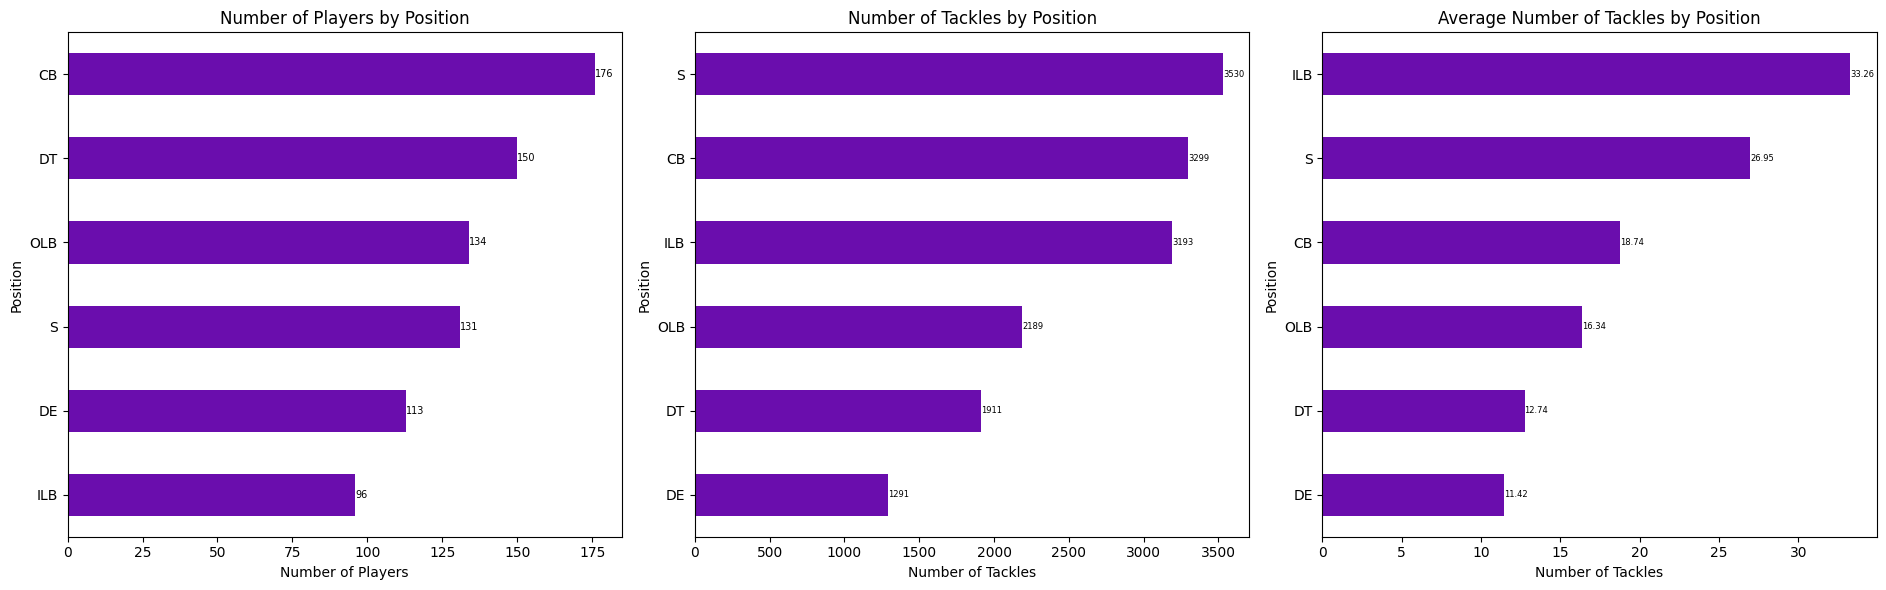

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(19, 6))

# Top 20 Players by Number of Tackles by position
pos_count = tackle_final.groupby('position')['nflId'].count()
bars1 = pos_count.sort_values().plot(kind='barh', color='#6A0DAD', ax=axes[0])
bars1.set_title('Number of Players by Position')
bars1.set_xlabel('Number of Players')
bars1.set_ylabel('Position')
for index, value in enumerate(pos_count.sort_values()):
    bars1.text(value, index, str(value), ha='left', va='center', color='black', fontsize=7)

# Top 20 Players by Number of Tackles by position
top_positions = tackle_final.groupby('position')['success_sum'].sum()
bars2 = top_positions.sort_values().plot(kind='barh', color='#6A0DAD', ax=axes[1])
bars2.set_title('Number of Tackles by Position')
bars2.set_xlabel('Number of Tackles')
bars2.set_ylabel('Position')
for index, value in enumerate(top_positions.sort_values()):
    bars2.text(value, index, str(value), ha='left', va='center', color='black', fontsize=6)

# Average Number of tackles by Position
adj_pos = top_positions / pos_count
bars3 = adj_pos.sort_values().plot(kind='barh', color='#6A0DAD', ax=axes[2])
bars3.set_title('Average Number of Tackles by Position')
bars3.set_xlabel('Number of Tackles')
bars3.set_ylabel('Position')
for index, value in enumerate(adj_pos.sort_values()):
    bars3.text(value, index, str(round(value, 2)), ha='left', va='center', color='black', fontsize=6)

plt.tight_layout()
plt.show()

The plots above demonstrate intriguing insights into the distribution of tackles across different positions. Cornerbacks (CB) emerge with the most significant number of players, followed by the second-highest total tackles, subsequently leading to the third-highest tackles-per-player ratio. Contrastingly, Inside Linebackers (ILB), possess the fewest players while displaying the highest tackle rate per player. These visuals underscore a compelling observation: positions with a higher count of players tend to accumulate more tackles owing to increased opportunities, influencing the overall tackle statistics. Moreover, the data highlights notable trends in positions like Inside Linebackers (ILB), Safeties (S), and Cornerbacks (CB), showcasing their higher tackle rates. This aligns with the understanding that specific positions often find themselves in situations conducive to potential tackles, thus encountering more opportunities for tackling and consequently recording a higher count of completed tackles. Such insights reveal how a player's position on the field directly correlates with their likelihood of engaging in tackling scenarios. Ultimately, these statistics neglect the contextual nuances of tackles, such as the ball carrier's position in open space relative to the defenders or the presence of blockers hindering the tackle attempts.

# **<center><span style="color:RebeccaPurple;">Feature Engineering</span></center>**
***

To enhance the understanding of factors influencing successful tackles, several key features were engineered:
1. `blockers`: A binary indicator (1 for presence, 0 for absence) denoting the presence of blockers. Expectantly, the probability of a successful tackle decreases in the presence of blockers as they impede a defender's ability to tackle.
2. `tack_side`: A binary indicator (1 for in front, 0 for behind) signifying the positioning of the defender concerning the pass catcher. Tackling from the front is intuitively perceived as easier than tackling from behind.
3. `pos_diff`: A continuous positive value representing the Euclidean distance between the pass catcher and the defender. A shorter distance indicates higher odds of completing a tackle.
4. `speed_diff`: A continuous value indicating the difference in speed between the pass catcher and the defender. A faster defender relative to the pass catcher may increase the likelihood of completing a tackle due to catching up.
5. `rel_angle`: A continuous value reflecting the relative angle between the pass catcher and the defender. Favorable angles, where both face each other, might increase the tackle probability compared to opposing directions.
6. `car_sideline`: A continuous value indicating the pass catcher's distance from the nearest sideline. Tackling near a sideline might facilitate easier tackles compared to tackles in the middle of the field.
7. `weight_dif`: A continuous value expressing the weight difference between the pass catcher and the defender. If the defender is heavier for example, it might be harder for the pass catcher to break a tackle, leading to a higher probability of completing a tackle.
8. `total_inches_tack`:  A continuous value representing the height of the defender. Shorter defenders might have an advantage as they can position themselves lower for better tackling success.

In [4]:
# Subset data to time of catch
catch = track.loc[(track['event'] == 'pass_outcome_caught') & (track['nflId'].notnull())]

# Add tackle outcome 
catch = pd.merge(catch, tackle_data, on = ['gameId', 'playId', 'nflId'], how = 'left')
catch['success'] = catch['success'].notnull().astype('int')

# Ball Carrier Data
carrier = play_data[['gameId', 'playId', 'nflId', 'ballCarrierDisplayName']]

# Add whether player had ball or not
catch = pd.merge(catch, carrier, on = ['gameId', 'playId', 'nflId'], how = 'left')
catch['ballCarrierDisplayName'] = catch['ballCarrierDisplayName'].notnull().astype('int')
catch = catch[['gameId', 'playId', 'nflId', 'x', 'y', 's', 'a',
            'dis', 'o', 'dir', 'success', 'ballCarrierDisplayName', 'playDirection']]

# Ball Carriers
carr = catch.loc[(catch['nflId'].isin(off_players)) & catch['ballCarrierDisplayName'] == 1]
carr = carr[['gameId', 'playId', 'nflId', 'x', 'y', 's', 'a', 'dis', 'o', 'dir', 'playDirection']]

# Defenders
defender = catch.loc[catch['nflId'].isin(def_players)]
defender = defender[['gameId', 'playId', 'nflId', 'x', 'y', 's', 'a', 'dis', 'o', 'dir', 'success']]

# Merge defender and carrier data 
final = pd.merge(defender, carr, on = ['gameId', 'playId'], suffixes=('_tack', '_car'), how = 'left')

# Determine whether there is a defender who can block
blocks = catch.loc[(catch['nflId'].isin(off_players)) & catch['ballCarrierDisplayName'] == 0]
blocks.reset_index(drop=True)
blockers = []

for _, row_a in final.iterrows():
    # Extract coordinates for carrier and tackler
    player1_coords = (row_a['x_car'], row_a['y_car'])
    player2_coords = (row_a['x_tack'], row_a['y_tack'])
    
    # Filter blockers based on gameId and playId
    df_b_filtered = blocks[(blocks['gameId'] == row_a['gameId']) & (blocks['playId'] == row_a['playId'])]
    
    # Check conditions for each row in filtered blockers
    found_blocker = any(
        (row_b['x'] > min(player1_coords[0], player2_coords[0])) and
        (row_b['x'] < max(player1_coords[0], player2_coords[0])) and
        (euclidean(player1_coords, (row_b['x'], row_b['y'])) < euclidean(player1_coords, player2_coords))
        for _, row_b in df_b_filtered.iterrows()
    )
    
    # Assign 1 if condition is met, otherwise 0
    blockers.append(1 if found_blocker else 0)

# Features    

# Presence of blocker
final['blockers'] = blockers

# 1 if defender is in front of the ball carrier, 0 else
def def_side(row):
    if row['playDirection'] == 'right' and row['x_tack'] > row['x_car']:
        return 1
    elif row['playDirection'] == 'right' and row['x_tack'] <= row['x_car']:
        return 0
    elif row['playDirection'] == 'left' and row['x_tack'] < row['x_car']:
        return 1
    elif row['playDirection'] == 'left' and row['x_tack'] >= row['x_car']:
        return 0
        
final['tack_side'] = final.apply(def_side, axis=1)

# Position Difference
final['pos_diff'] = np.sqrt((final['x_tack'] - final['x_car'])**2 + (final['y_tack'] - final['y_car'])**2)

# Speed Difference
final['speed_diff'] = final['s_tack'] - final['s_car']

# Relative Angle
final['rel_angle'] = np.abs(final['o_car'] - final['o_tack'])
final.replace([np.inf, -np.inf], 0, inplace=True)

# Distance from nearest sideline
final['car_sideline'] = np.where(final['y_car'] >= (53.3 / 2), 53.3 - final['y_car'], final['y_car'])

    
# Height and Weight
final = pd.merge(final, player_data[['nflId', 'weight', 'total_inches']], left_on='nflId_tack', right_on='nflId', how='left')
final.rename(columns={'weight': 'weight_tack', 'total_inches': 'total_inches_tack'}, inplace=True)
final.drop('nflId', axis=1, inplace=True)

final = pd.merge(final, player_data[['nflId', 'weight', 'total_inches']], left_on='nflId_car', right_on='nflId', how='left')
final.rename(columns={'weight': 'weight_car', 'total_inches': 'total_inches_car'}, inplace=True)
final.drop('nflId', axis=1, inplace=True)

# Weight Difference
final['weight_dif'] = final['weight_tack'] - final['weight_car']

final.head()


,gameId,playId,nflId_tack,x_tack,y_tack,s_tack,a_tack,dis_tack,o_tack,dir_tack,...,tack_side,pos_diff,speed_diff,rel_angle,car_sideline,weight_tack,total_inches_tack,weight_car,total_inches_car,weight_dif
0,2022090800,56,38577.00,78.11,28.74,3.35,2.62,0.32,349.47,357.71,...,1,7.07,-1.26,235.20,17.71,242,72,191,72,51
1,2022090800,56,41239.00,92.15,29.96,3.62,2.86,0.37,186.16,157.65,...,0,13.53,-0.99,71.89,17.71,280,73,191,72,89
2,2022090800,56,42816.00,70.62,7.66,2.60,4.14,0.27,331.57,278.33,...,1,29.42,-2.01,217.30,17.71,184,71,191,72,-7
3,2022090800,56,43294.00,78.15,37.85,5.88,1.23,0.59,140.96,178.50,...,1,2.83,1.27,26.69,17.71,208,73,191,72,17
4,2022090800,56,43298.00,92.11,33.14,1.34,2.21,0.13,159.12,203.53,...,0,12.50,-3.27,44.85,17.71,240,77,191,72,49


# **<center><span style="color:RebeccaPurple;">Feature Analysis</span></center>**
***

Here are visualizations depicting the distributions of the above engineered features, showcasing the distinction between successful and unsuccessful tackles for comparative analysis.

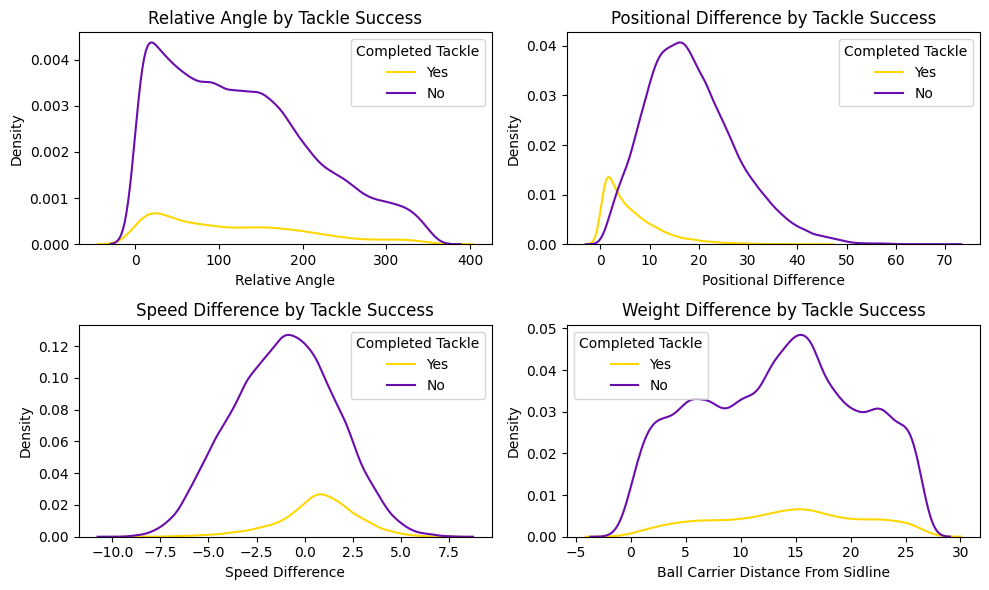

In [5]:
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)  # First subplot
sns.kdeplot(x=final['rel_angle'], hue = final['success'], palette = {0: '#6A0DAD', 1: '#FFD700'})
plt.title('Relative Angle by Tackle Success')
plt.xlabel('Relative Angle')
plt.legend(title='Completed Tackle', labels=['Yes', 'No'])

plt.subplot(2, 2, 2)  # Second subplot
sns.kdeplot(x=final['pos_diff'], hue = final['success'], palette = {0: '#6A0DAD', 1: '#FFD700'})
plt.title('Positional Difference by Tackle Success')
plt.xlabel('Positional Difference')
plt.legend(title='Completed Tackle', labels=['Yes', 'No'])

plt.subplot(2, 2, 3)  # Third subplot
sns.kdeplot(x=final['speed_diff'], hue = final['success'], palette = {0: '#6A0DAD', 1: '#FFD700'})
plt.title('Speed Difference by Tackle Success')
plt.xlabel('Speed Difference')
plt.legend(title='Completed Tackle', labels=['Yes', 'No'])

plt.subplot(2, 2, 4)  # Fourth subplot
sns.kdeplot(x=final['car_sideline'], hue = final['success'], palette = {0: '#6A0DAD', 1: '#FFD700'})
plt.title('Weight Difference by Tackle Success')
plt.xlabel('Ball Carrier Distance From Sidline')
plt.legend(title='Completed Tackle', labels=['Yes', 'No'])

plt.tight_layout()
plt.show()

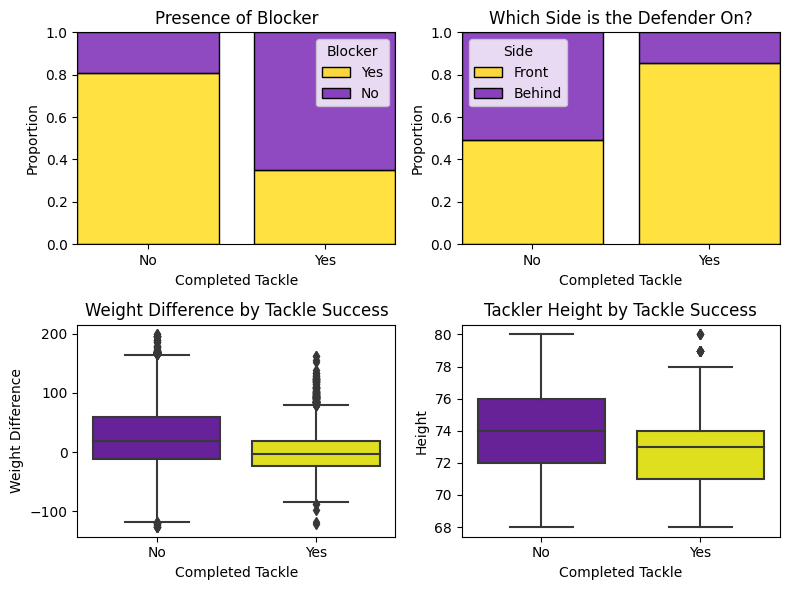

In [6]:
plt.figure(figsize=(8, 6))

plt.subplot(2, 2, 1)  # First subplot
sns.histplot(final, x='success', hue='blockers',
    multiple="fill", stat="proportion",
    discrete=True, shrink=.8, palette = {0: '#6A0DAD', 1: '#FFD700'})
plt.title('Presence of Blocker')
plt.xlabel('Completed Tackle')
plt.legend(title='Blocker', labels=['Yes', 'No'])
plt.xticks([0, 1], ['No', 'Yes'])

plt.subplot(2, 2, 2)  # Second subplot
sns.histplot(final, x='success', hue='tack_side',
    multiple="fill", stat="proportion",
    discrete=True, shrink=.8, palette = {0: '#6A0DAD', 1: '#FFD700'})
plt.title('Which Side is the Defender On?')
plt.xlabel('Completed Tackle')
plt.legend(title='Side', labels=['Front', 'Behind'])
plt.xticks([0, 1], ['No', 'Yes'])

plt.subplot(2, 2, 3)  # Third subplot
sns.boxplot(x='success', y='weight_dif', data=final, palette = {0: '#6A0DAD', 1: 'yellow'})
plt.title('Weight Difference by Tackle Success')
plt.xlabel('Completed Tackle')
plt.ylabel('Weight Difference')
plt.xticks([0, 1], ['No', 'Yes'])

plt.subplot(2, 2, 4)  # Fourth subplot
sns.boxplot(x='success', y='total_inches_tack', data=final, palette = {0: '#6A0DAD', 1: 'yellow'})
plt.title('Tackler Height by Tackle Success')
plt.xlabel('Completed Tackle')
plt.ylabel('Height')
plt.xticks([0, 1], ['No', 'Yes'])

plt.tight_layout()
plt.show()

The plots illustrate a distinct divergence in distributions between successful and unsuccessful tackles. Notably, disparities are prominent in positional discrepancies, speed variations, blocker presence, the defender's positioning concerning the pass catcher, and disparities in height. While the relative angle and weight differences showcase some variance, the emphasis is on larger dispersions in the unsuccessful tackle distributions, particularly evident in the weight difference—an observation depicted both as a density plot and box plot. In summary, the discernible disparities within the distributions for each chosen feature signify their relevance as impactful attributes for our model.

# **<center><span style="color:RebeccaPurple;">Finding the Best Model</span></center>**
***

Here, we assess various algorithms for predicting the probability of completing a tackle, employing methods such as Logistic Regression, Random Forest, Gradient Boosting, and XGBoost. To gauge the performance of these models in our predictions, we measure several key metrics including accuracy, precision, recall, F1 Score, and present a Confusion Matrix.

In [7]:
features = ['blockers', 'pos_diff', 'speed_diff', 'tack_side', 'rel_angle', 'car_sideline', 'weight_dif',
           'total_inches_tack']

X = final[features]
y = final['success']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1234)

### <span style="color:RebeccaPurple;">Logistic Regression</span>

In [8]:
lr = LogisticRegression(max_iter=650)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9216190170253774
Precision: 0.7312633832976445
Recall: 0.4850852272727273
F1 Score: 0.5832621690862511
Confusion Matrix:
[[10793   251]
 [  725   683]]


### <span style="color:RebeccaPurple;">Random Forest</span>

In [9]:
rf = RandomForestClassifier(n_estimators=100, random_state=1234)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9245904272406039
Precision: 0.768
Recall: 0.4772727272727273
F1 Score: 0.5886990801576872
Confusion Matrix:
[[10841   203]
 [  736   672]]


### <span style="color:RebeccaPurple;">Gradient Boosting<span>

In [10]:
gb = GradientBoostingClassifier(n_estimators=100, random_state=1234)  # Adjust hyperparameters as needed
gb.fit(X_train, y_train)

y_pred = gb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9245101188564087
Precision: 0.7560175054704595
Recall: 0.49076704545454547
F1 Score: 0.5951765719207579
Confusion Matrix:
[[10821   223]
 [  717   691]]


### <span style="color:RebeccaPurple;">XGBoost<span>

In [11]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=1234)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9233858014776742
Precision: 0.7414893617021276
Recall: 0.4950284090909091
F1 Score: 0.5936967632027257
Confusion Matrix:
[[10801   243]
 [  711   697]]


Throughout these model evaluations, overall accuracy remained relatively consistent. However, this metric wasn't deemed the most suitable due to the significant class imbalance – there are notably more negative observations than positive ones. This mirrors real-world scenarios, where only a single player can make a tackle amidst 11 defensive players on the field. Consequently, we focused on precision and recall, aiming to minimize false positives and false negatives, respectively. Since our ultimate goal is to evaluate player tackling performance, both precision and recall are crucial. Hence, we primarily relied on the F1 Score as it offers a balanced view of these metrics. Given the prevalence of negative examples, our priority was to reduce false negatives. Across models, logistic regression yielded the lowest F1 Score, as anticipated in an imbalanced dataset, while XGBoost showcased the highest F1 Score. This aligns with the XGBoost confusion matrix, illustrating the fewest false negatives among the models evaluated.

# **<center><span style="color:RebeccaPurple;">Optimize Parameters Using RandomSearchCV</span></center>**
***

In this phase, we executed a Random Search on hyperparameters to fine-tune our XGBoost model resulting in fewer false positives and false negatives. Despite observing marginal improvements, these refinements hold significance and promise for enhancing model performance.

In [12]:
cv_grid = {'max_depth': randint(2,6), 
           'min_child_weight': randint(1,4),
          'subsample': uniform(0.6, 0.4), 
            'max_delta_step': randint(0,10),
          'learning_rate': uniform(0.05,0.35)}
k = StratifiedKFold(n_splits=5)
csv = RandomizedSearchCV(xgb.XGBClassifier(objective="binary:logistic", random_state=1234), cv_grid, scoring = 'roc_auc', cv = k)

csv.fit(X_train, y_train)

xgb_model = xgb.XGBClassifier(**csv.best_params_)
xgb_model.fit(X_train, y_train)

print('Optimal Parameters:')
print(csv.best_params_)
print()
y_pred = xgb_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Optimal Parameters:
{'learning_rate': 0.10732780826067884, 'max_delta_step': 7, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.814284629228184}

Accuracy: 0.925634436235143
Precision: 0.759698275862069
Recall: 0.5007102272727273
F1 Score: 0.603595890410959
Confusion Matrix:
[[10821   223]
 [  703   705]]


# **<center><span style="color:RebeccaPurple;">Model Analysis</span></center>**
***

In this section, we delve into a comprehensive evaluation of our predictive model. Rigorous assessment is important for gauging the model's efficacy,so we investigate multiple facets of its performance. Through various visualizations and metrics, we aim to dissect the predictive prowess, understand its behavior across different scenarios, and highlight key factors driving its decisions. The evaluation encompasses several characteristics, from the discriminative capacity brought by ROC curves and precision-recall curves to the crucial insights provided by a feature importance plot and the model's learning trajectory seen through learning curve plots.

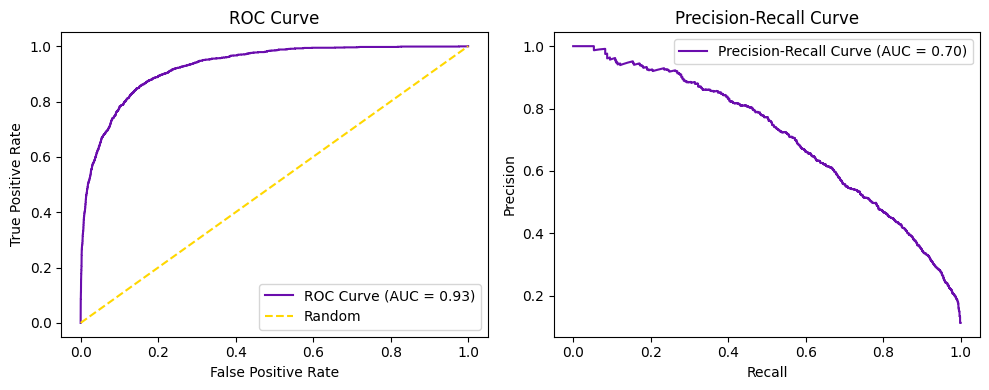

In [13]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)  # First subplot
# ROC Curve
y_scores = xgb_model.predict_proba(X_val)[:, 1] 
fpr, tpr, thresholds = roc_curve(y_val, y_scores)
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_score(y_val, y_scores)), color='#6A0DAD')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random', color='#FFD700')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.subplot(1, 2, 2)  # Second subplot
# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_val, y_scores)
plt.plot(recall, precision, label='Precision-Recall Curve (AUC = {:.2f})'.format(auc(recall, precision)), color='#6A0DAD')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()

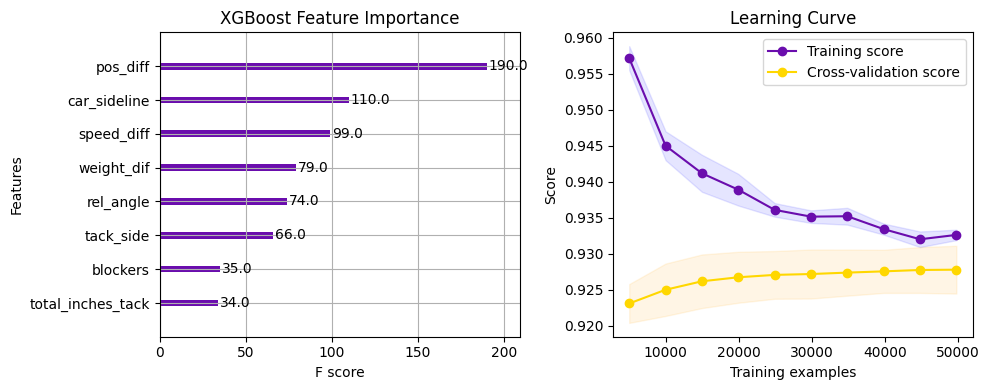

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Feature Importance
xgb.plot_importance(xgb_model, color='#6A0DAD', ax=axes[0])
axes[0].set_title("XGBoost Feature Importance")

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    xgb_model, X, y, cv=k, scoring='roc_auc', train_sizes=np.linspace(0.1, 1.0, 10)
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

axes[1].fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="blue")
axes[1].fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="orange")
axes[1].plot(train_sizes, train_scores_mean, 'o-', color='#6A0DAD', label="Training score")
axes[1].plot(train_sizes, test_scores_mean, 'o-', color='#FFD700', label="Cross-validation score")
axes[1].set_xlabel("Training examples")
axes[1].set_ylabel("Score")
axes[1].legend(loc="best")
axes[1].set_title("Learning Curve")

plt.tight_layout()
plt.show()

1. The ROC curve (top-left) visually represents the trade-off between true positive rate and false positive rate across different threshold values. A curve closer to the upper-left corner of the plot indicates better performance, indicating higher True Positive Rate (TPR) while maintaining lower False Positive Rate (FPR). Additionally, the area under the ROC curve (AUC-ROC) quantifies the model's performance; a higher AUC value (closer to 1) suggests better discrimination between positive and negative classes. In essence, the ROC curve helps in assessing the model's ability to distinguish between classes across varying thresholds, aiding in selecting the optimal threshold for your specific use case. Our model has an AUC-RUC of 0.93, which suggests that the model has strong predictive power, as it can separate the classes well. It implies that there's a 93% chance that the model will be able to distinguish between successful and unsuccessful tackles.

2. The precision-recall curve (top-right) evaluates a model's performance by showing how well it balances precision (the ability to avoid false positives) and recall (the ability to find all positive instances) at different thresholds. Here, an AUC of 0.7 indicates that the model performs reasonably well but might have some limitations in its precision-recall trade-off. It suggests that the model is moderately successful in identifying relevant instances (recall) while maintaining a decent level of precision.

3. The feature importance plot (bottom-left) gives us insight into how impactful each feature that we included is on the model's prediction. A higher importance would indicate a more substantial impact on the model's predictions. Here, we see that the distance between the pass catcher and the defender of interest is the most important feature. This is in line with our expectations as this is typically the most obvious indicator when determining whether a defender can make a tackle. 

4. The learning curve plot (bottom-right) helps us better understand the model's performance concerning the dataset size. As we can see, we see a narrowing in the gab between the training and cross-validation curves. This would suggest better generalization, indicating that the model is not overfitting, which is exaclty what we want.

<div class="alert alert-block alert-info">While the default threshold probabilty for predicting positive examples is 0.5, this may not necessarily be the best threshold for an inbalanced dataset. Below we compute the optimal threshold probability, which results in great performance from our model on the validation set.</div>

In [15]:
# Predicted Probabilities
predicted_probabilities = xgb_model.predict_proba(X_test)[:, 1]

# Define a range of thresholds (0.1 to 0.9 with step 0.1)
thresholds = np.arange(0.1, 1.0, 0.1)
f1_scores = []
best_threshold = None
best_f1_score = 0

# Calculate precision and recall for each threshold
for threshold in thresholds:
    y_pred = (predicted_probabilities > threshold).astype(int)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    f1_scores.append(f1)# F1-score calculation
    if f1 > best_f1_score:
        best_f1_score = f1
        best_threshold = threshold
# Print Optimal Threshold Probability      
print(f"Best threshold: {best_threshold:.2f}")


Best threshold: 0.30


In [16]:
probs = xgb_model.predict_proba(X_val)[:, 1]
probs[probs > best_threshold] = 1
print("Accuracy:", accuracy_score(y_val, probs.astype(int)))
print("Precision:", precision_score(y_val, probs.astype(int)))
print("Recall:", recall_score(y_val, probs.astype(int)))
print("F1 Score:", f1_score(y_val, probs.astype(int)))

Accuracy: 0.9163989720526823
Precision: 0.6263121063680895
Recall: 0.6383737517831669
F1 Score: 0.6322854115153657


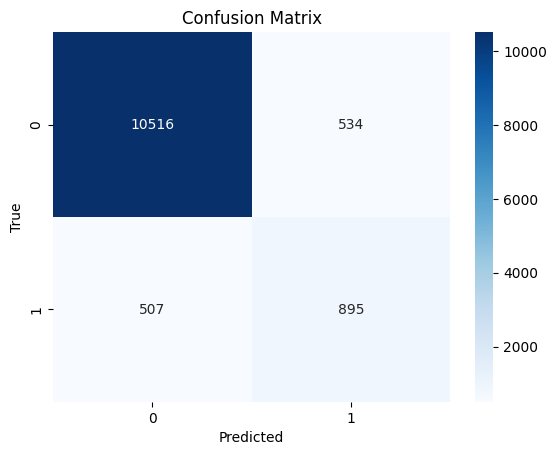

In [17]:
# Confusion Matrix using new threshold
cm = confusion_matrix(y_val, probs.astype(int))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# **<center><span style="color:RebeccaPurple;">Player Evaluation</span></center>**
***

Now that our model demonstrates reliable prediction capabilities, our focus shifts to evaluating players' tackling performances. Given the inherent variance in tackling opportunities across positions, our analysis centers on comparing players within their respective positions to derive meaningful insights. The first plot showcases the top 5 players within each position based on their total number of tackles. The second plot features these same players, presenting their tackle success ratio. This ratio is derived from the player's total tackle count against their expected tackle count, calculated as the summation of their predicted probabilities obtained from our model. In our assessment, a success ratio of 1.0 denotes an expected performance level. Ratios below this benchmark indicate underperformance by the player of interest, while those above signify overperformance within the set criteria.

In [18]:
# Make Predictions using model
pred_probs = xgb_model.predict_proba(final[features])[:, 1]
# Probabilty of tackle
final['pred_probs'] = pred_probs
# Actual Tackle Prediction
final['preds'] = np.where(final['pred_probs'] > best_threshold, 1, 0)

player_predictions = final.groupby('nflId_tack').sum()[['success', 'pred_probs', 'preds']]

# Player names with predictions
name_preds = pd.merge(player_predictions, player_data[['nflId', 'displayName', 'position']], left_on='nflId_tack', right_on='nflId')
name_preds['success_diff'] = name_preds['success'] - name_preds['preds']
name_preds['probs_ratio'] = name_preds['success'] / name_preds['pred_probs']

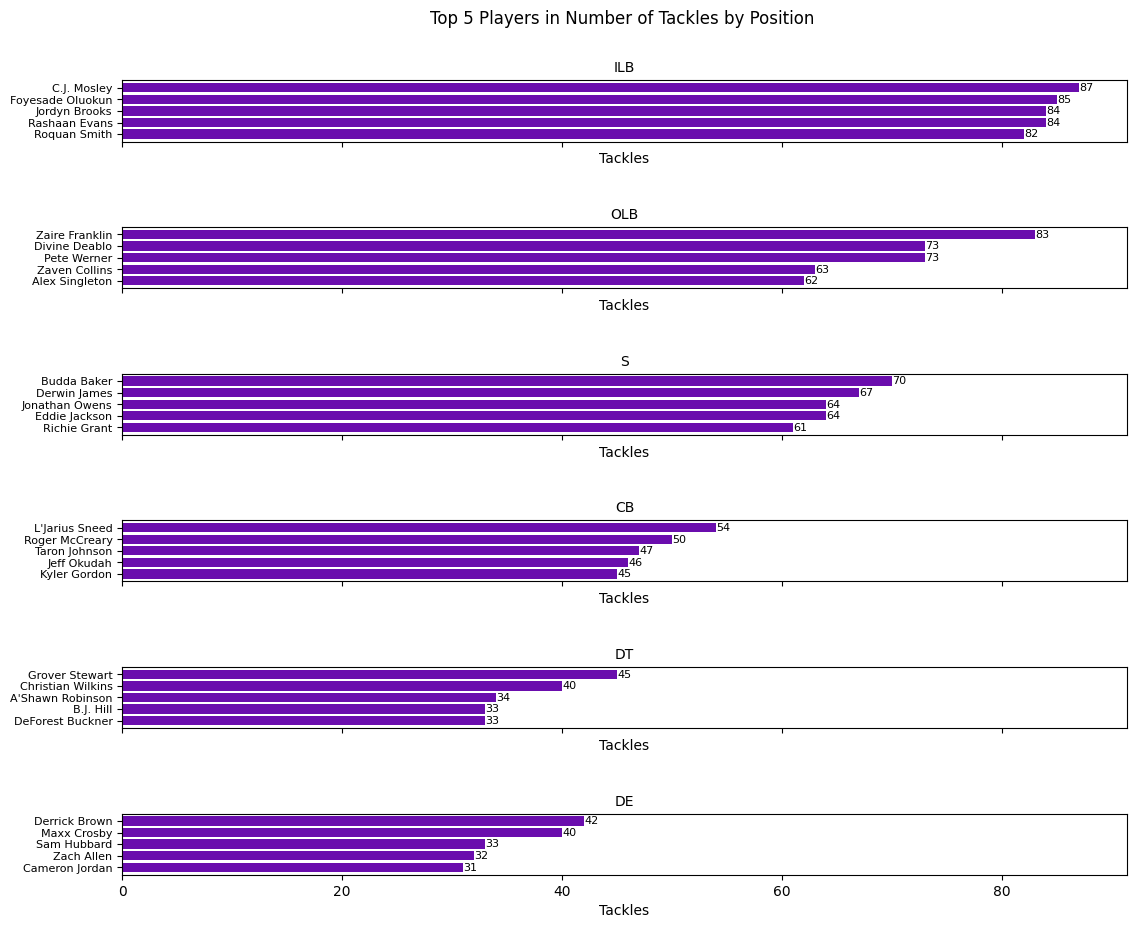

In [19]:
# Top 5 players by number of tackles by position
top_players_by_position = tackle_final.groupby('position').apply(lambda x: x.nlargest(5, 'success_sum'))
max_success_sums = top_players_by_position.groupby(level=0)['success_sum'].max()
sorted_positions = max_success_sums.sort_values(ascending=False).index

fig, axes = plt.subplots(nrows=len(sorted_positions), figsize=(12, 10), sharex=True)

# Plotting the top 5 players by position as horizontal bar charts
for i, position in enumerate(sorted_positions):
    data = top_players_by_position.loc[position]
    sorted_data = data.sort_values('success_sum')  # Sort data within each subplot
    
    ax = axes[i] if len(sorted_positions) > 1 else axes  # Handle single subplot case
    bars = ax.barh(sorted_data['displayName'], sorted_data['success_sum'], color='#6A0DAD')
    ax.set_title(f'{position}', fontsize=10)
    ax.set_xlabel('Tackles', fontsize=10)
    ax.tick_params(axis='y', which='major', labelsize=8)  # Adjust label size for better readability

    # Annotate bars with their respective 'success_sum' values
    for bar, value in zip(bars, sorted_data['success_sum']):
        ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, str(value),
                va='center', ha='left', color='black', fontsize=8)

# Add a figure title
fig.suptitle('Top 5 Players in Number of Tackles by Position', fontsize=12, x = 0.545, y=0.95)

        
plt.tight_layout(pad=3.0)  # Increase spacing between subplots
plt.show()

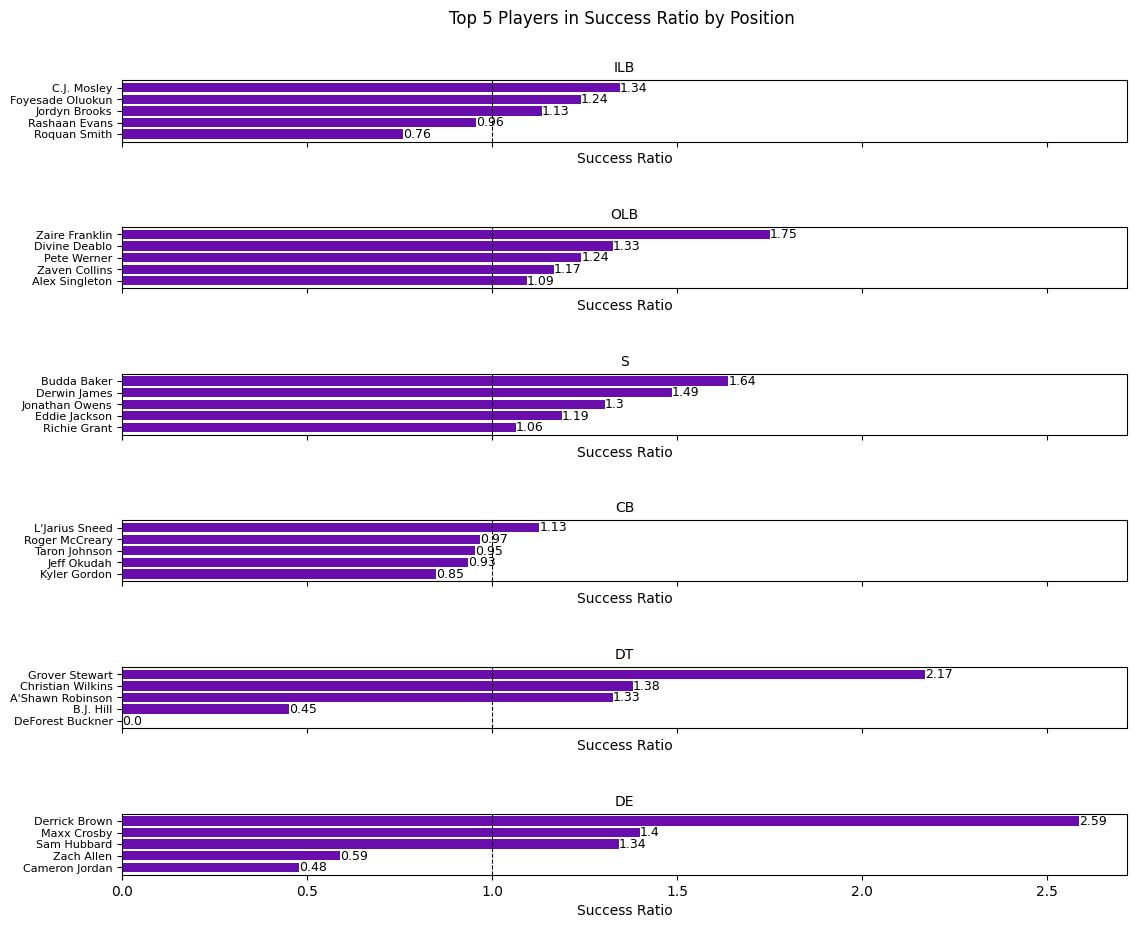

In [20]:
fig, axes = plt.subplots(nrows=len(sorted_positions), figsize=(12, 10), sharex=True)

# Plotting the top 5 players by position as horizontal bar charts
for i, position in enumerate(sorted_positions):
    data = top_players_by_position.loc[position]
    sorted_data = data.sort_values('success_sum')  # Sort data within each subplot
    
    ax = axes[i] if len(sorted_positions) > 1 else axes  # Handle single subplot case
    ratios = name_preds.loc[name_preds['displayName'].isin(sorted_data['displayName'].tolist())]['probs_ratio'].sort_values()
    bars = ax.barh(sorted_data['displayName'], ratios, color='#6A0DAD')
    ax.set_title(f'{position}', fontsize=10)
    ax.set_xlabel('Success Ratio', fontsize=10)
    ax.tick_params(axis='y', which='major', labelsize=8)  # Adjust label size for better readability

    # Annotate bars with their respective 'success_sum' values
    for bar, value in zip(bars, ratios):
        ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, str(round(value, 2)),
                va='center', ha='left', color='black', fontsize=9)
        
    # Add a vertical dotted line at zero
    ax.axvline(x=1, color='black', linestyle='--', linewidth=0.8)
        
# Add a figure title
fig.suptitle('Top 5 Players in Success Ratio by Position', fontsize=12, x=0.545, y=0.95)        

plt.tight_layout(pad=3.0)  # Increase spacing between subplots
plt.show()

The comparison based solely on the total number of tackles among the top 5 players in each position shows a general similarity in performance. However, when evaluating their tackle success ratio, a more nuanced view emerges. Consider Inside Linebackers (ILB), where the range among players is only 5 tackles. Yet, analyzing their success ratios reveals disparities: Raashan Evans and Roquan Smith underperform compared to C.J. Mosley, who demonstrates an overperformance trend. This paints a much different picture than simple box scores which make these players appear to perform similarly. The most notable differences emerge among Defensive Ends (DE). Derrick Brown notably exceeds expectations, completing over twice the expected tackles, while Cameron Jordan falls significantly short, accomplishing less than half of the expected tackles. In summary, our model serves as a metric for comparing player performance, offering detailed insights that uncover substantial variations in tackling abilities, unrepresented by conventional box score metrics.